# Crack detection in concrete

In [7]:
# For colab
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# For colab
#!pip install split-folders
#!pip install timm

## Importing necessary libraries

In [181]:
import pickle
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders
import numpy as np
from torchsummary import summary
from torch import nn
import copy
import time
import timm
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
import sys
from time import sleep
from datetime import datetime
from torchvision.datasets.folder import default_loader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




## Define constant variables

In [219]:
BASELINE = "baseline"
BILATERAL = "bilateral"
CANNY = 'canny'
CLAHE = 'clahe'


BATCH_SIZE = 64

# Change model to run by changing these two:
GRAY_SCALE = True
RUN_TYPE = CLAHE

if GRAY_SCALE:
    model_type = f'{RUN_TYPE}_grey_'
else:
    model_type = f'{RUN_TYPE}_color_'

## Loading the dataset

In [220]:
positive_dataset_path = './Concrete Crack Images for Classification/Positive/'
negative_dataset_path = './Concrete Crack Images for Classification/Negative/'
dataset_path = "Concrete Crack Images for Classification"

In [221]:
# For colab

#positive_dataset_path = './drive/MyDrive/ML/Concrete Crack Images for Classification/Positive/'
#negative_dataset_path = './drive/MyDrive/ML/Concrete Crack Images for Classification/Negative/'
#dataset_path = "Concrete Crack Images for Classification"

In [222]:
# Comment out this cell in colab
pos_images = os.listdir(positive_dataset_path)
neg_images = os.listdir(negative_dataset_path)

### Display random positive and negative image

Number of images with cracks: 20000
Number of images without crack: 20000
Image with a crack


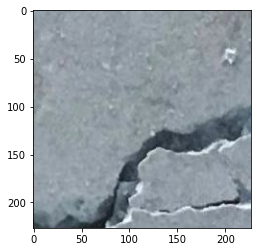

Image without a crack


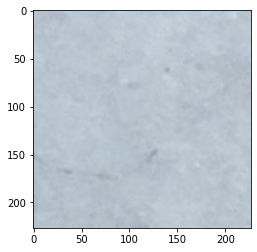

In [223]:
# Comment out this cell in colab

print('Number of images with cracks:', len(pos_images))
print('Number of images without crack:', len(neg_images))
rand_pos_path = pos_images[random.randint(0,len(pos_images))]
rand_pos_img = cv2.imread(f'{positive_dataset_path}{rand_pos_path}')
rand_neg_path = neg_images[random.randint(0,len(neg_images))]
rand_neg_img = cv2.imread(f'{negative_dataset_path}{rand_neg_path}')
print("Image with a crack")
plt.imshow(rand_pos_img)
plt.show()
print("Image without a crack")
plt.imshow(rand_neg_img)
plt.show()

### Divide into train, test and validation

In [224]:
root_dir = 'Images'
pos_dir = 'Positive'
neg_dir = 'Negative'

In [225]:
# For google colab
#root_dir = './drive/MyDrive/ML/Images/'

In [226]:
def split_data():
    splitfolders.ratio(input=dataset_path, output=root_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None )
# split_data()

In [227]:
train_pos = os.listdir(f'{root_dir}/train/{pos_dir}')
train_neg = os.listdir(f'{root_dir}/train/{neg_dir}')
val_pos = os.listdir(f'{root_dir}/val/{pos_dir}')
val_neg = os.listdir(f'{root_dir}/val/{neg_dir}')
test_pos = os.listdir(f'{root_dir}/test/{pos_dir}')
test_neg = os.listdir(f'{root_dir}/test/{neg_dir}')


In [228]:
print("Number of train positive: ", len(train_pos))
print("Number of train neg: ", len(train_neg))
print("Number of val positive: ", len(val_pos))
print("Number of val neg: ", len(val_neg))
print("Number of test positive: ", len(test_pos))
print("Number of test neg: ", len(test_neg))

Number of train positive:  14000
Number of train neg:  14000
Number of val positive:  3000
Number of val neg:  3000
Number of test positive:  3000
Number of test neg:  3000


## Filter

In [229]:
class Dataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(Dataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        tensor = transforms.ToTensor()(img)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [230]:
class NoiseReductionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(NoiseReductionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about d, sigmaColor and sigmaSpace (15, 75, 75)
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        tensor = transforms.ToTensor()(noiseless)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [231]:
class EdgeDetectionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(EdgeDetectionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'low_tresh' in parameter_dict
        assert 'high_tresh' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.low_tresh = parameter_dict['low_tresh']
        self.high_tresh = parameter_dict['high_tresh']

    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about minVal and maxVal (100, 200) also need to look at aperture_size (size of Sobel kernel) and  L2gradient
        edge = cv2.Canny(img, self.low_tresh, self.high_tresh)
        tensor = transforms.ToTensor()(edge)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [232]:
class ContrastEnhancingDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(ContrastEnhancingDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'clipLimit' in parameter_dict
        assert 'tileGridSize' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.clipLimit = parameter_dict['clipLimit']
        self.tileGridSize = parameter_dict['tileGridSize']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about clipLimit=2.0, tileGridSize=(8,8)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        enhanced = clahe.apply(img)
        tensor = transforms.ToTensor()(enhanced)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [233]:
### -------- Need to take a deeper look into the gabor filter ------
class GaborFilterDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(GaborFilterDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about sig = 1, th = 0, lm = 1.0, gm = 0.02, ps = 0 and kernel_size
        kernel_size = 31
        kernel = cv2.getGaborKernel((kernel_size, kernel_size), 1, 0, 1.0, 0.02, 0, ktype=cv2.CV_32F)
        res = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        tensor = transforms.ToTensor()(res)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

## Dataloader and transform

In [234]:
def get_dataset(root_dir, mode, classe, parameter_dict):
    path = os.path.join(root_dir, mode)
    dataset = classe(path, parameter_dict)
    return dataset

In [235]:
def dataloader(root_dir, mode, classe, parameter_dict):
    dataset = get_dataset(root_dir, mode, classe, parameter_dict)
    # Can have batchsize in dataloader
    data_loader = DataLoader(
        dataset,
        batch_size = BATCH_SIZE,
        shuffle = True
    )
    return data_loader, dataset

In [236]:
if RUN_TYPE == BASELINE:
    dataloder_train, dataset_train = dataloader(root_dir, "train", Dataset, {'gray_scale': GRAY_SCALE})
    dataloader_val, dataset_val = dataloader(root_dir, "val", Dataset, {'gray_scale': GRAY_SCALE})
elif RUN_TYPE == BILATERAL:
    # Bilateral
    parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100}
    dataloder_train, dataset_train = dataloader(root_dir, "train", NoiseReductionDataset, parameter_dict )
    dataloader_val, dataset_val = dataloader(root_dir, "val", NoiseReductionDataset, parameter_dict)
elif RUN_TYPE == CANNY:
    parameter_dict = {'gray_scale': GRAY_SCALE, 'low_tresh': 50, 'high_tresh': 230}
    dataloder_train, dataset_train = dataloader(root_dir, "train", EdgeDetectionDataset, parameter_dict )
    dataloader_val, dataset_val = dataloader(root_dir, "val", EdgeDetectionDataset, parameter_dict)
elif RUN_TYPE == CLAHE:
    parameter_dict = {'gray_scale': GRAY_SCALE, 'clipLimit': 1.0, 'tileGridSize': (8,8)}
    dataloder_train, dataset_train = dataloader(root_dir, "train", ContrastEnhancingDataset, parameter_dict )
    dataloader_val, dataset_val = dataloader(root_dir, "val", ContrastEnhancingDataset, parameter_dict)
else:
    raise Exception("Unknown run tye")

print("Running ", RUN_TYPE, " with grayscale ", GRAY_SCALE)


Running  clahe  with grayscale  True


In [237]:
print(f"Length of dataset: {len(dataset_train)}, classes in dataset: {dataset_train.classes}")
inputs, classes, indices = next(iter(dataloder_train))
print("Shape of image:", inputs.shape)

Length of dataset: 28000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])


### Function for visualizing images

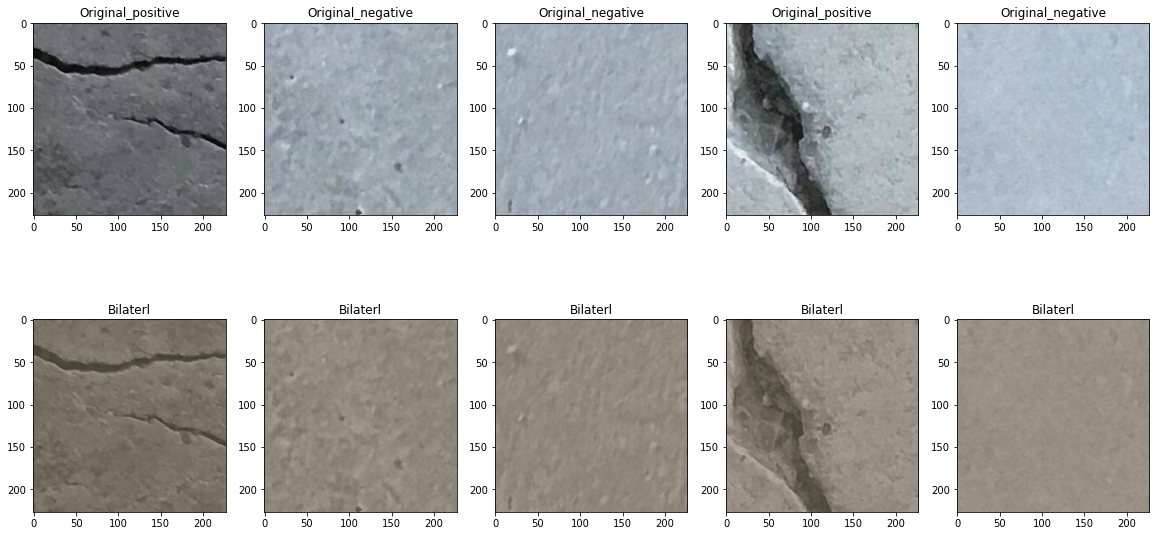

In [238]:
def show_ten_img(img_arr, indices, classname, filter_type):
    f, axarr = plt.subplots(2,5, figsize = (20, 10))
    pos = 'Original_positive'
    neg = 'Original_negative'
    for i in range(0, 5):
        # Plot original
        index = indices[i]
        org_path = dataloder_train.dataset.samples[index][0]
        img_org = cv2.imread(org_path)
        axarr[0,i].imshow(img_org)
        titel = pos if classname[i]==1 else neg
        axarr[0,i].set_title(titel)

        # Plot with filter
        img = np.transpose(img_arr[i].numpy(), (1, 2, 0))
        mean = np.array(IMAGENET_DEFAULT_MEAN)
        std = np.array(IMAGENET_DEFAULT_STD)
        img = img*std+mean
        axarr[1,i].imshow(img)
        axarr[1,i].set_title(filter_type)

    plt.show()

show_ten_img(inputs, indices, classes, 'Bilaterl')

In [239]:
def show_img(img_arr, index, classname=None):
    org_path = dataloder_train.dataset.samples[index][0]
    img_org = cv2.imread(org_path)
    plt.imshow(img_org)
    plt.title('Original')
    plt.show()
    img = np.transpose(img_arr.numpy(), (1, 2, 0))
    mean = np.array(IMAGENET_DEFAULT_MEAN)
    std = np.array(IMAGENET_DEFAULT_STD)
    img = img*std+mean
    plt.imshow(img)
    if classname!=None:
        title = "POSITIVE" if classname==1 else "NEGATIVE"
        plt.title(title)
    plt.show()

# Display first image in dataloader
# Dataloader has shuffle = True, so it will be a new 
# image every time the dataloader is defined again. 
# show_img(inputs[0],  indices[0], classes[0])

## Create basic cnn model

In [240]:
class ConvolutionalNet(nn.Module):
    def __init__(self, gray_scale=False):
        super().__init__()
        input_dimention = 1 if gray_scale else 3
        self.conv1 = nn.Conv2d(input_dimention, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(73926, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [241]:
GRAY_SCALE

True

In [242]:
RUN_TYPE

'clahe'

In [243]:
# defining the model
model = ConvolutionalNet(gray_scale=GRAY_SCALE)

In [244]:
# Define dataloaders and dataset sizes:
TRAIN_SIZE = len(dataset_train)
VAL_SIZE = len(dataset_val)

dataloaders = {'train': dataloder_train, 'val': dataloader_val}
dataset_sizes = {'train':TRAIN_SIZE, 'val':VAL_SIZE}

In [245]:
# Defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Define scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [246]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [247]:
# Set model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

In [248]:
summary(model, inputs[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 223, 223]             156
         MaxPool2d-2          [-1, 6, 111, 111]               0
           Dropout-3          [-1, 6, 111, 111]               0
            Linear-4                  [-1, 120]       8,871,240
            Linear-5                   [-1, 84]          10,164
            Linear-6                    [-1, 2]             170
Total params: 8,881,730
Trainable params: 8,881,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 3.41
Params size (MB): 33.88
Estimated Total Size (MB): 37.48
----------------------------------------------------------------


## Train model

In [249]:
#Training the model
def train(model, epochs, dataloaders, dataset_sizes, optimizer, criterion, scheduler=None):
    losses, accuracies  = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for i, data in enumerate(dataloaders[phase],0):
                inputs, classes = data[0].to(device), data[1].to(device)
                
                # Print loading bar
                sys.stdout.write('\r')
                percentage = 100/dataset_sizes[phase]*BATCH_SIZE*i
                sys.stdout.write("Epoch: %d %s:[%-20s] %.2f%%" % (epoch, phase, '='*round(percentage/5), percentage))
                sys.stdout.flush()

                optimizer.zero_grad() # Set gradient to zero
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Train model
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, classes)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
                
            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return model, best_acc, losses, accuracies

In [250]:
model, best_acc, losses, accuracies = train(model, 10, dataloaders, dataset_sizes, optimizer, criterion)

Starting epoch 0
Epoch: 0 train:[=======             ] 36.80%

KeyboardInterrupt: 

## Save model

In [ ]:
def save_model(dir, model, best_acc, losses, accuracies):
    '''
        Saves model naming it according to time stamp
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'{model_type}{dt_string}'
    path = f'{dir}/{model_name}_model.pth'
    path_json = f'{dir}/{model_name}_history.json'
    torch.save(model, path)

    #accuracies = {'train': [x.item() for x in accuracies['train']], 'val': [x.item() for x in accuracies['val']]}
    with open(path_json, 'wb') as f:
      dic = {'best acc': best_acc.item(), 'losses': losses, 'accuracy': accuracies}
      pickle.dump(dic, f)

In [ ]:
# For colab
# cd drive/MyDrive/ML

In [ ]:
model_dir = './models'

In [ ]:
save_model(model_dir, model, best_acc, losses, accuracies)

## Plotting

In [73]:
def plot_accuracy(history):
    accuracy = history['accuracy']
    plt.plot(accuracy['train'])
    plt.plot(accuracy['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(history):
    loss = history['losses']
    plt.plot(loss['train'])
    plt.plot(loss['val'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower left")
    plt.show()
  
def load_history(path):
    with open(path, 'rb') as f:
        history = pickle.load(f)
    return history

def plotting(path_to_history):
    history = load_history(path_to_history)
    plot_loss(history)
    plot_accuracy(history)

In [74]:
# For colab
# cd models

In [75]:
# history_path = 'model_07_01_2022_15:52:55_history.json'


history_path = 'models/bilateral_grey_20_01_2022_17:27:39_history.json'

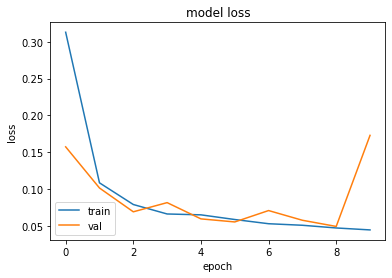

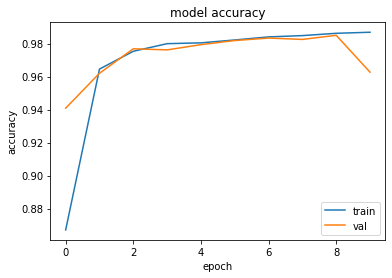

In [76]:
plotting(history_path)

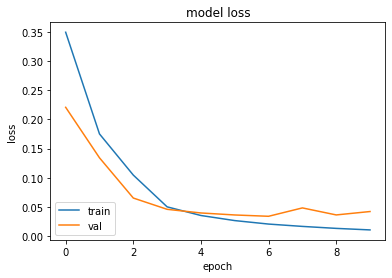

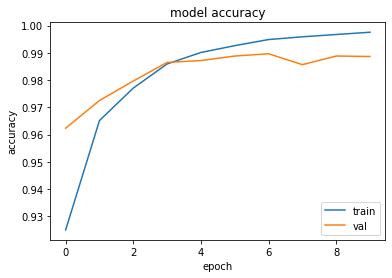

In [41]:
plotting(history_path)

## resNet50

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [162]:
resnet50 = models.resnet50(pretrained=False)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [163]:
summary(resnet50, inputs[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

### Train model

In [164]:
TRAIN_SIZE = len(dataset_train)
VAL_SIZE = len(dataset_val)

In [165]:
dataloaders = {'train': dataloder_train, 'val': dataloader_val}
dataset_sizes = {'train':TRAIN_SIZE, 'val':VAL_SIZE}

In [166]:
criterion = nn.CrossEntropyLoss() # Which loss?
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [167]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [168]:
model, best_acc, losses, accuracies = train(resnet50, 10, dataloaders, dataset_sizes, optimizer, criterion, scheduler)

Starting epoch 0
Epoch: 0 train:[                    ] 0.23%

KeyboardInterrupt: 

In [61]:
model_dir = './models/'
# For colab
#model_dir = 'content/drive/MyDrive/ML/models/resnet50'

In [129]:
def save_model(dir, model, best_acc, losses, accuracies):
    '''
        Saves model naming it according to time stamp
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'resnet50_{dt_string}'
    path = f'{dir}/{model_name}_model.pth'
    path_json = f'{dir}/{model_name}_history.json'
    torch.save(model, path)

    #accuracies = {'train': [x.item() for x in accuracies['train']], 'val': [x.item() for x in accuracies['val']]}
    with open(path_json, 'wb') as f:
      dic = {'best acc': best_acc.item(), 'losses': losses, 'accuracy': accuracies}
      pickle.dump(dic, f)

In [ ]:
save_model(model_dir, model, best_acc, losses, accuracies)